Loading keypoint data for multiple animals...


Loading keypoints: 100%|████████████████| 21/21 [00:00<00:00, 71.21it/s]


Loaded 42 total recordings (videos x animals).
Data successfully loaded and config updated.
Formatting data for the model...
Fitting PCA model...
Plotting PCA results...


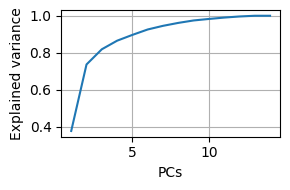

>=90.0% of variance exlained by 6 components.


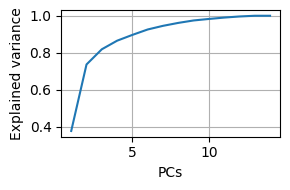

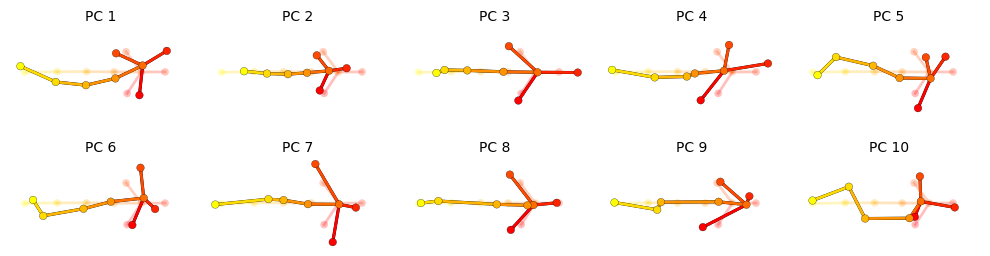

Initializing the model...
1. Fitting AR model...
Outputs will be saved to
DeepLabCut/examples/11_1_identity_true/2025_11_16-22_50_50


 49%|█████████████████▏                 | 25/51 [00:27<00:28,  1.09s/it]

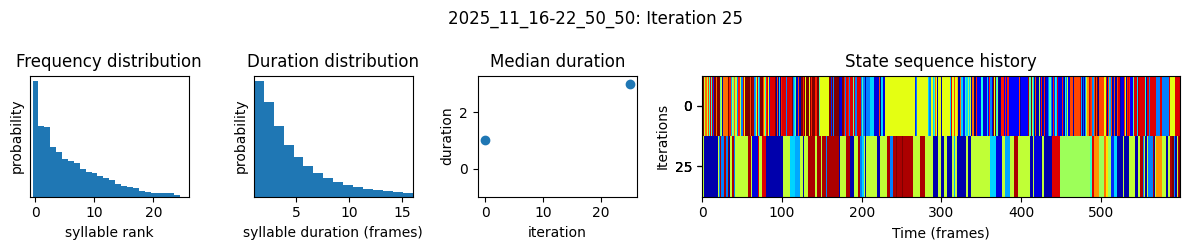

 98%|██████████████████████████████████▎| 50/51 [00:55<00:01,  1.17s/it]

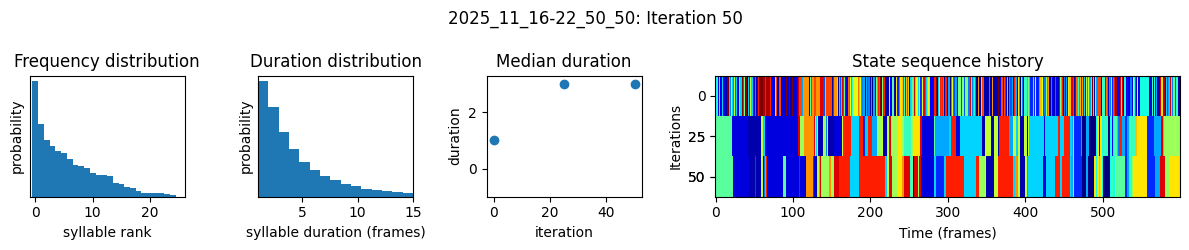

100%|███████████████████████████████████| 51/51 [00:57<00:00,  1.12s/it]


2. Fitting full model to find syllables...
Outputs will be saved to
DeepLabCut/examples/11_1_identity_true/2025_11_16-22_50_50


 12%|███▉                            | 25/201 [09:33<1:06:33, 22.69s/it]

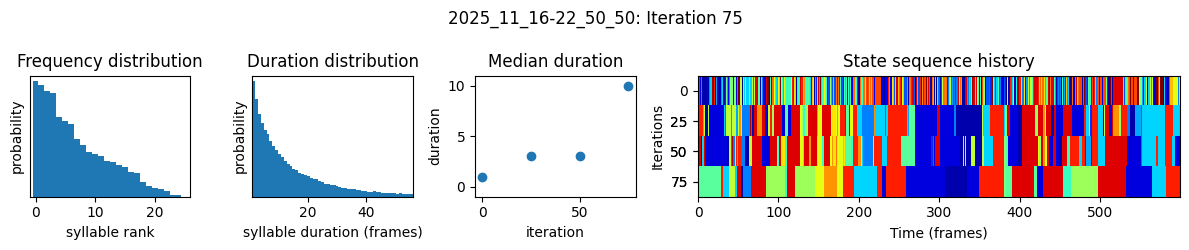

 25%|███████▉                        | 50/201 [19:18<1:03:56, 25.41s/it]

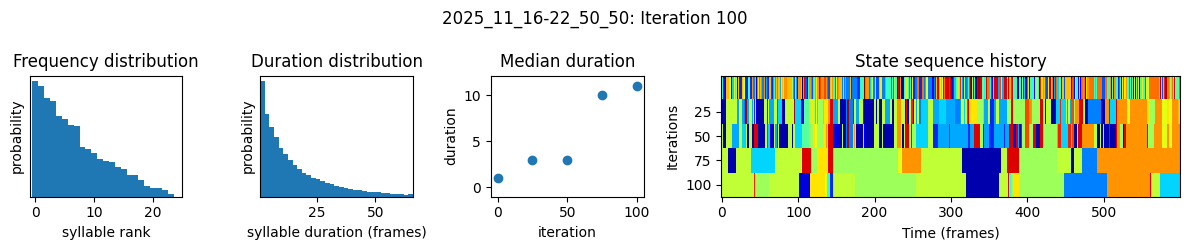

 37%|████████████▋                     | 75/201 [29:37<57:57, 27.60s/it]

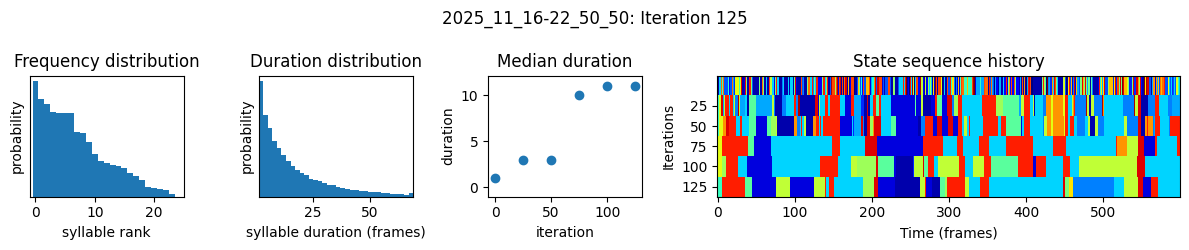

 50%|████████████████▍                | 100/201 [39:36<42:22, 25.17s/it]

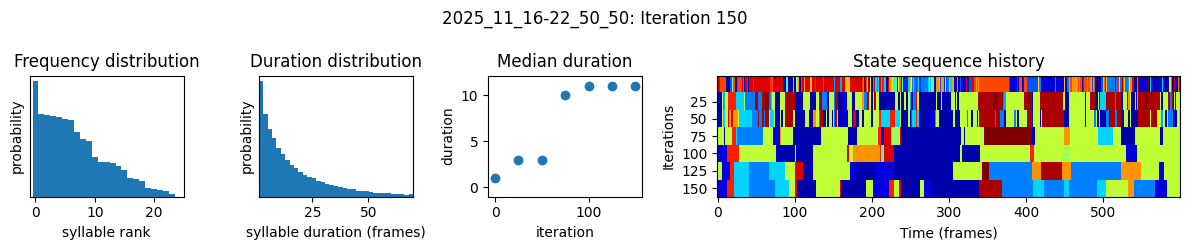

 62%|████████████████████▌            | 125/201 [49:33<28:46, 22.72s/it]

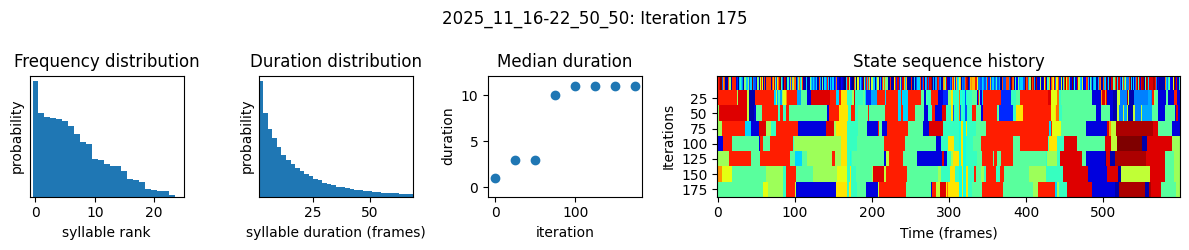

 75%|████████████████████████▋        | 150/201 [59:22<20:52, 24.56s/it]

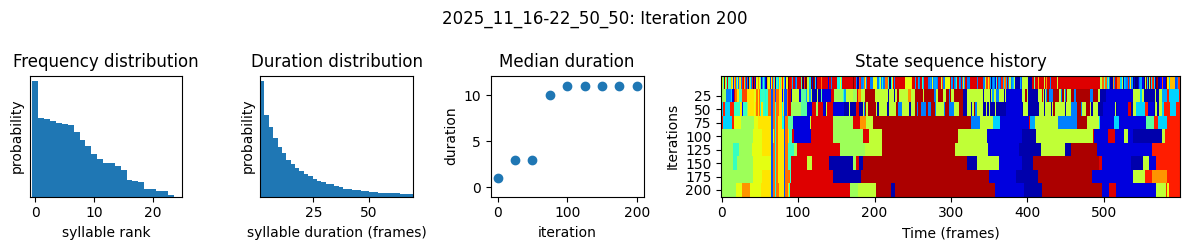

 87%|██████████████████████████▉    | 175/201 [1:08:56<09:36, 22.16s/it]

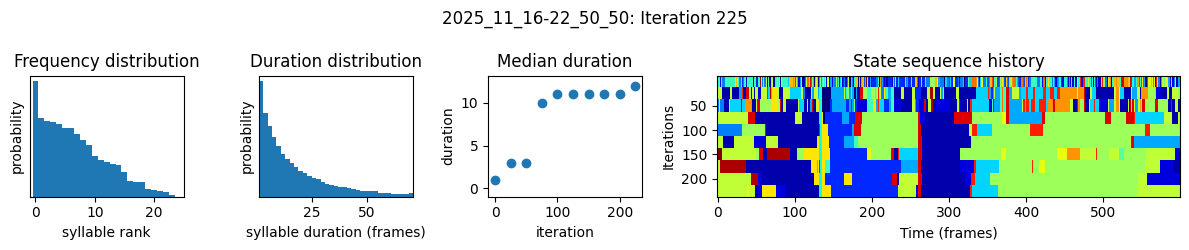

100%|██████████████████████████████▊| 200/201 [1:18:53<00:24, 24.44s/it]

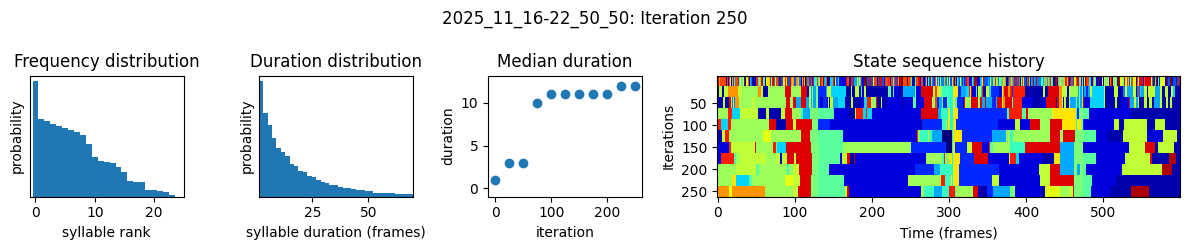

100%|███████████████████████████████| 201/201 [1:19:18<00:00, 23.67s/it]


Applying final model to data to generate results.h5...


Applying model: 100%|███████████████| 500/500 [3:56:47<00:00, 28.41s/it]


Saved results to
DeepLabCut/examples/11_1_identity_true/2025_11_16-22_50_50/results.h5
Model fitting complete! Results are saved in a folder named: 2025_11_16-22_50_50
Loading results...
Generating trajectory plots for ALL syllables...
Saving trajectory plots to DeepLabCut/examples/11_1_identity_true/2025_11_16-22_50_50/trajectory_plots


Generating trajectory plots: 100%|██████| 25/25 [00:06<00:00,  4.05it/s]


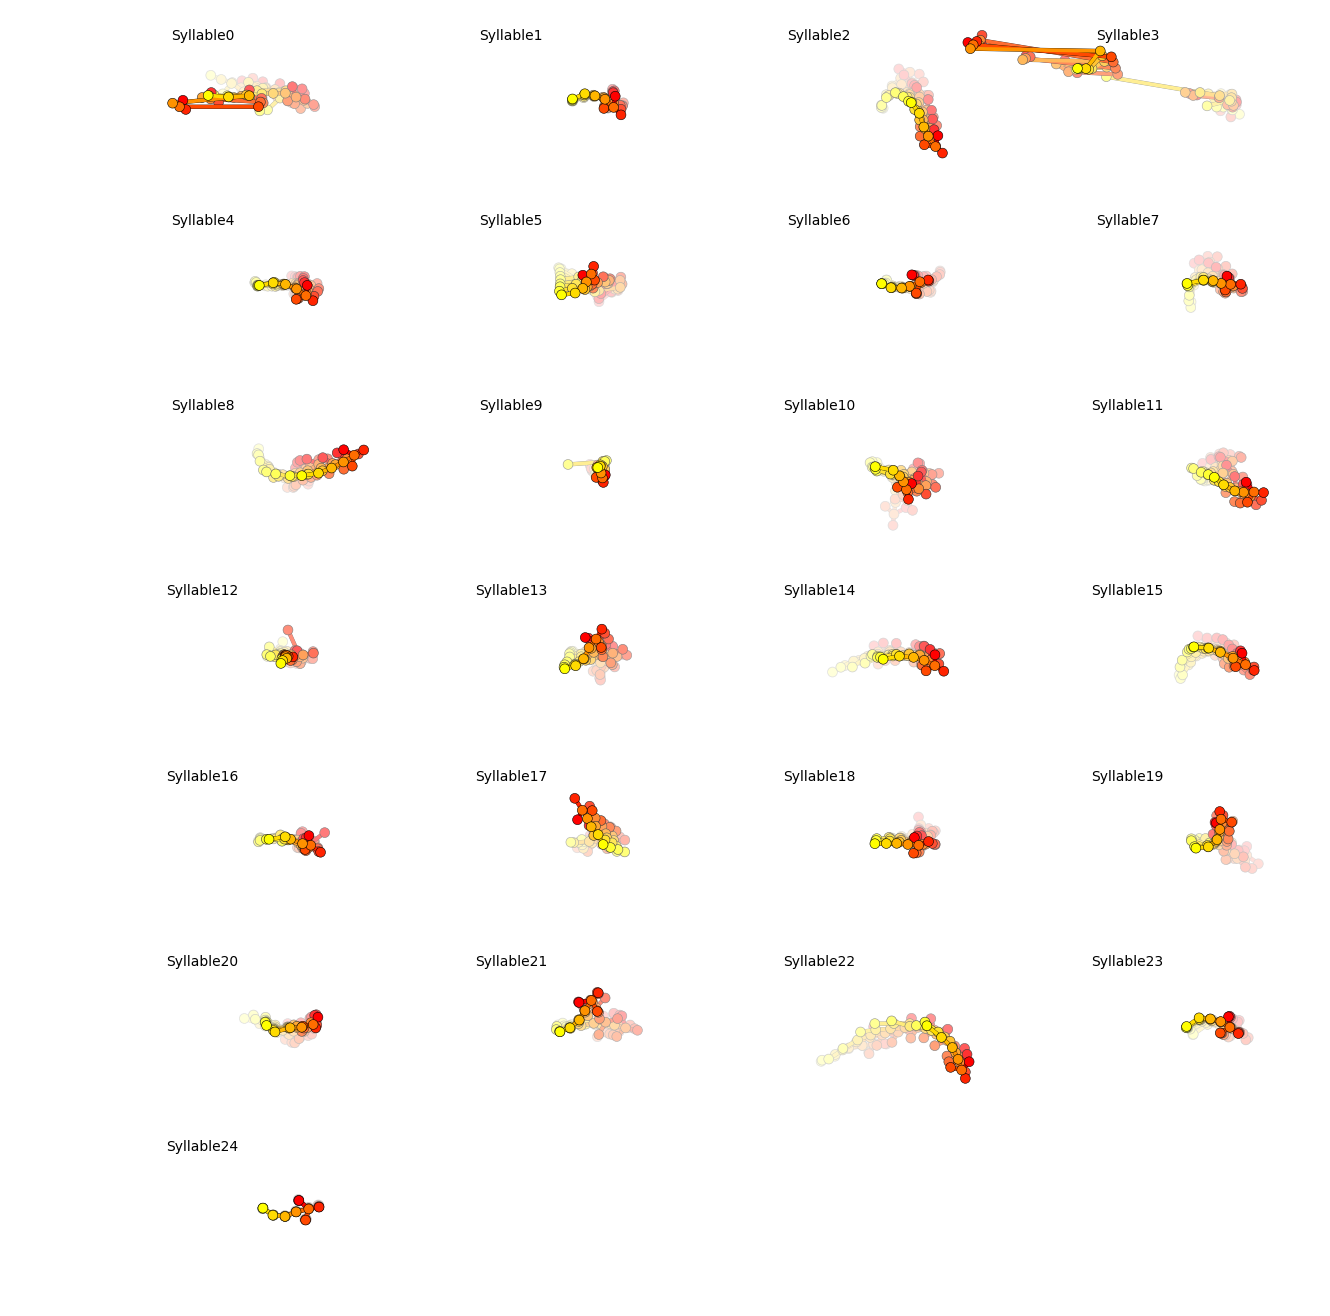

Generating grid movies for ALL syllables...
Writing grid movies to DeepLabCut/examples/11_1_identity_true/2025_11_16-22_50_50/grid_movies
Using window size of 144 pixels


Generating grid movies:   0%|                    | 0/25 [00:00<?, ?it/s]/opt/miniconda3/envs/keypoint_moseq/lib/python3.10/subprocess.py:1796: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Generating grid movies: 100%|███████████| 25/25 [00:15<00:00,  1.65it/s]

Grid movies saved to the '2025_11_16-22_50_50/grid_movies' folder. All done!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Frequency distribution'}, xlabel='syllable rank', ylabel='probability'>)

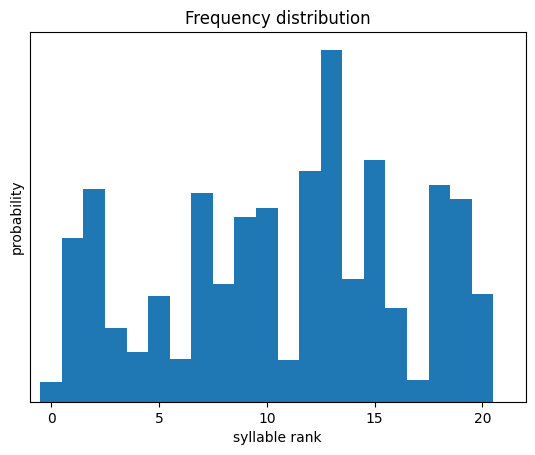

In [3]:
# modified code to give me as much grid movies/trajectory plots as possible- but now they look a little different

import keypoint_moseq as kpms
import os
import numpy as np
import jax
from jax_moseq.utils.debugging import convert_data_precision
jax.config.update("jax_enable_x64", True)

# -------------------------------------------------------------------------

project_dir = 'DeepLabCut/examples/11_1_identity_true'


# deeplabcut .h5 files
dlc_data_path = '11_1_identity_true/videos'

video_dir = '11_1_identity_true/videos'

# create project directory if it doesn't exist
os.makedirs(project_dir, exist_ok=True)

# -------------------------------------------------------------------------

config = kpms.load_config(project_dir)

#changes 11_13
# set the number of syllables you want to find
config['n_states'] = 25

# increase stickiness to favor longer syllables. this is main contributor?
config['kappa'] = 1e6  # Default is 1e6, higher is 'stickier'

# -------------------------------------------------------------------------

print("Loading keypoint data for multiple animals...")
# load_keypoints will automatically find all .h5 files
# and create separate dictionary keys for mouse1 and mouse2.
# For 20 videos, you will now have 40 recordings.
coordinates, confidences, bodyparts = kpms.load_keypoints(dlc_data_path, 'deeplabcut')

print(f"Loaded {len(coordinates)} total recordings (videos x animals).")

# update the config to use the correct bodypart list
single_animal_bodyparts = ['left_ear', 'snout', 'right_ear', 'head', 'body1', 'body2', 'body3', 'body4']
config['bodyparts'] = single_animal_bodyparts
config['use_bodyparts'] = single_animal_bodyparts

print("Data successfully loaded and config updated.")

# -------------------------------------------------------------------------

print("Formatting data for the model...")
data, metadata = kpms.format_data(coordinates, confidences, **config)
data = convert_data_precision(data)

# -------------------------------------------------------------------------

print("Fitting PCA model...")
pca = kpms.fit_pca(**data, **config)
kpms.save_pca(pca, project_dir)

print("Plotting PCA results...")
kpms.plot_scree(pca, project_dir=project_dir)
kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config)

print("Initializing the model...")
model = kpms.init_model(data, pca=pca, **config)

# -------------------------------------------------------------------------

# fit the AR model first to learn movement dynamics
print("1. Fitting AR model...")
model, model_name = kpms.fit_model(
    model,
    data,
    metadata,
    project_dir,
    ar_only=True,      
    num_iters=50       
)

# load the AR-fitted model and continue fitting to find syllables
print("2. Fitting full model to find syllables...")
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=50) # Load the model we just saved

# fit the full model
model, model_name = kpms.fit_model(
    model,
    data,
    metadata,
    project_dir,
    model_name=model_name,
    ar_only=False,     
    start_iter=current_iter,
    num_iters=current_iter + 200 
)

# -------------------------------------------------------------------------

print("Applying final model to data to generate results.h5...")
results = kpms.apply_model(
    model,
    data,
    metadata,
    project_dir=project_dir,
    model_name=model_name,
    **config
)
print(f"Model fitting complete! Results are saved in a folder named: {model_name}")


## step 7: video examples of syllables

# use the keys of the original 'coordinates' dictionary as the list of recording names
recording_names = list(coordinates.keys())

if not recording_names:
    print("Error: 'coordinates' dictionary is empty. Cannot find recordings.")
else:
    # use retrieved list of recording names
    video_paths = kpms.find_matching_videos(recording_names, video_dir, as_dict=True)
    
    print("Loading results...")
    results = kpms.load_results(project_dir, model_name)

    # MODified ocde for trajectory plots
    # -------------------------------------------------------------------------
    print("Generating trajectory plots for ALL syllables...")

    trajectory_sampling_options = {
        "mode": "density",
        "n_neighbors": 2    # Default is 50
    }

    kpms.generate_trajectory_plots(
        coordinates, 
        results, 
        project_dir, 
        model_name,
        min_frequency=0.0,
        pre=1,                   
        post=1,                  
        min_duration=1,
        sampling_options=trajectory_sampling_options,
        **config
    )

    # and modified for grid movies
    # -------------------------------------------------------------------------
    print("Generating grid movies for ALL syllables...")
    
    kpms.generate_grid_movies(
        results, 
        project_dir,
        model_name,
        coordinates=coordinates,
        min_frequency=0.0,
        pre=1,               
        post=2,              
        min_duration=1,      
        rows=3,
        cols=3,
        keypoints_only=True,
        **config
    )
    print(f"Grid movies saved to the '{model_name}/grid_movies' folder. All done!")

kpms.plot_syllable_frequencies(project_dir, model_name)